### **Trading Strategy for Apple Inc. Using GARCH Model in Python**

Apple Inc. is a global American technology firm with headquarters in Cupertino, California. Apple is the world's largest firm by market capitalization as of June 2022, the fourth-largest personal computer vendor by unit sales, the second-largest producer of mobile phones, and the largest technological business by revenue (totalling US$365.8 billion in 2021). Together with Alphabet (Google), Amazon, Meta (Facebook), and Microsoft, it is one of the Big Five American information technology firms.

The analysis is driven by the need to analyse financial data trends. The data was sourced by downloading the daily historical Apple stock prices from the Yahoo Finance website between January 1, 2013, and March 1, 2023. The data includes the open, close, low, high, and adjusted close prices of the stock for a period of 10 years. The objectives of the project are to create a trading strategy through volatility analysis and identifying patterns in the price of Apple stock during the previous 10 years.

The GARCH model has found widespread application in the modelling of financial time series. Since they are given by stochastic difference equations in discrete time, the likelihood function is simpler to handle than it is in continuous-time models, and since financial data is typically collected at discrete intervals, GARCH (1,1) models are preferred over other stochastic volatility models by many economists. When the variance of the error term is not constant, GARCH models are utilized. The error term is hence heteroskedastic. 

In [38]:
#---- Importing Libraries ----
import pandas as pd
import numpy as np
from arch import arch_model
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.express as px
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


In [39]:
# ---- Retrieve stock data from yahoo finance ----
ap = yf.download('aapl', start='2013-01-01', end='2023-03-01')

ap.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.837118,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.624598,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.161526,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.066454,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.109699,458707200


In [40]:
#---- Create a dataframe with only the 'Close' column ----
df = ap[['Close']]
df.head()

,Close
Date,
2013-01-02,19.608213
2013-01-03,19.360714
2013-01-04,18.821428
2013-01-07,18.710714
2013-01-08,18.761070


In [41]:
#---- Resample to daily frequency and fill missing values with the previous observation ----
df = df.resample('D').last()

#---- Fill missing values with the previous observation ----
df = df.fillna(method='bfill')

The plot below shows the series of the Apple Inc. closing prices from 2013 to 2023. The time series plot appears in clusters, high in certain periods and low in certain periods. It evolves over time in a continuous manner and is thus, volatile. An upward trend is also visible in the series but this can be confirmed by decomposition of the time series into the trend, seasonality, and residuals.

In [42]:
#---- Plot closing prices ----
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Closing Price'))
fig.update_layout(title='Apple Stock Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()

Decomposing the time series gives the plot below. From the plot, one can see that there is a slow upward trend present in the series. There is also evidence of seasonality.

In [43]:
#---- Decompose time series into trend, seasonality, and residual components ----
result = seasonal_decompose(df['Close'], model='multiplicative', period=365)
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=df.index, y=result.trend, name='Trend'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=result.seasonal, name='Seasonality'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=result.resid, name='Residual'), row=3, col=1)
fig.update_layout(title='Decomposition of Apple Stock Prices', xaxis_title='Date')
fig.show()

In [44]:
#---- Create the lag plot for the closing prices ----
fig = px.scatter(x=df['Close'][:-5], y=df['Close'][5:], title='Apple Stock Price Lag Plot', labels={'x': 'Price (lag=0)', 'y': 'Price (lag=5)'})
fig.show()

From the ACF plot below, one can see that the plot decays to zero slowly, meaning the shock affects the process permanently. 

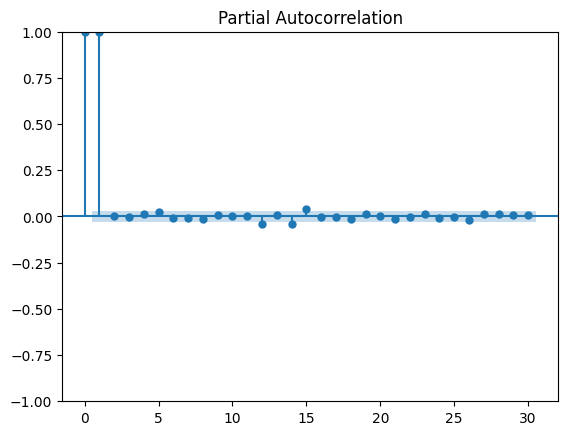

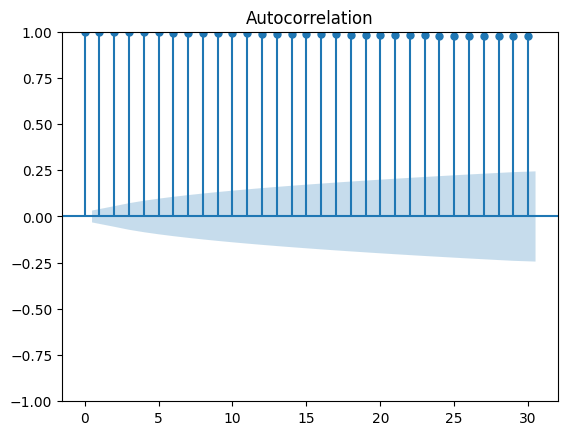

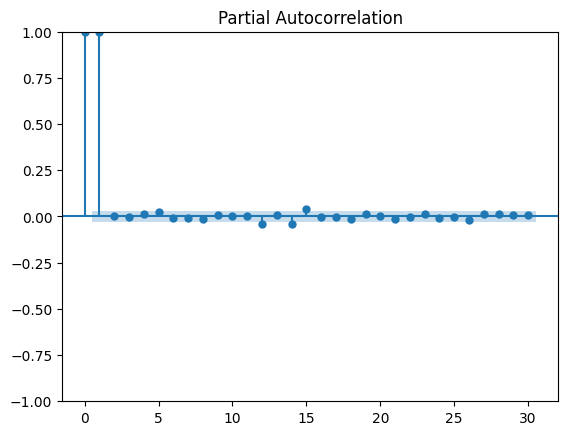

In [45]:
#---- Plot ACF and PACF ----
plot_acf(df['Close'], lags=30)
plot_pacf(df['Close'], lags=30, method='ywm')

In [46]:
#---- Test for stationarity using Augmented Dickey-Fuller Test ----
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    p_value = result[1]
    if p_value < 0.05: 
        print("We reject the null hypothesis. The time series is stationary".format(p_value)) 
    else:
        print("We fail to reject the null hypothesis. The time series is non-stationary".format(p_value))

In [47]:
adf_test(df['Close'])

ADF Statistic: -0.09193632533405967
p-value: 0.9502358072266948
Critical Values:
   1%: -3.432121001005083
   5%: -2.862322530123271
   10%: -2.567186552156024
We fail to reject the null hypothesis. The time series is non-stationary


We can conclude that we need to perform time series analysis on the daily return (log return) of the stock prices. The plot below shows the ACF plot of the differenced log returns.

In [48]:
#---- Create a new column for returns ----
df['Returns'] = np.log(df['Close']).diff()
df = df.dropna()

In [49]:
adf_test(df['Returns'])

ADF Statistic: -16.26145917189307
p-value: 3.562262807726752e-29
Critical Values:
   1%: -3.432121001005083
   5%: -2.862322530123271
   10%: -2.567186552156024
We reject the null hypothesis. The time series is stationary


In [50]:
# Plot the daily returns of Apple using plotly express 
fig = px.line(x=df.index, y=df['Returns'], title='Daily Returns of Apple') 
fig.show()

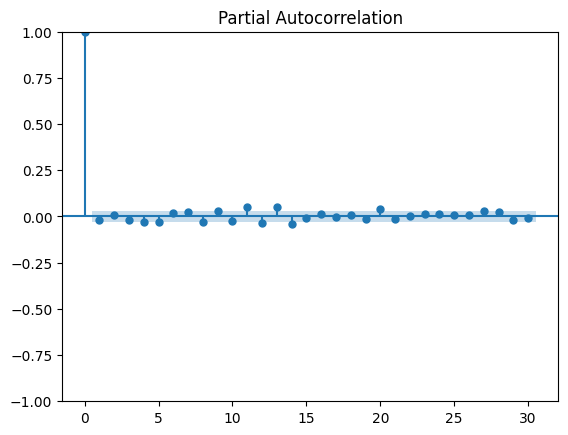

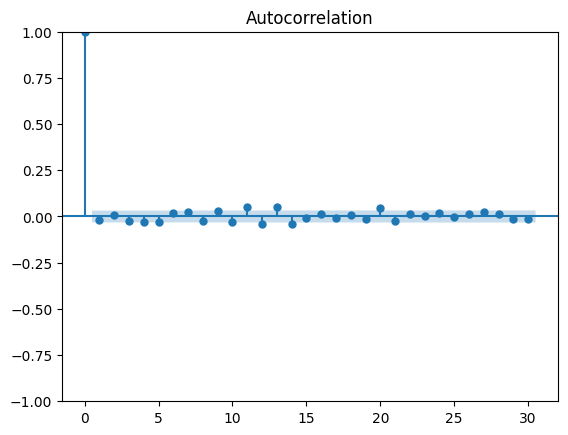

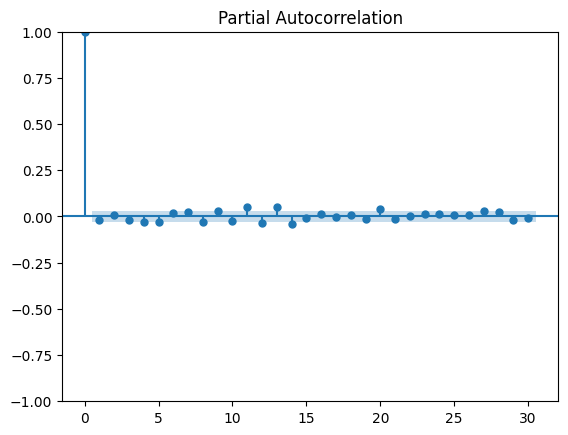

In [51]:
#---- Plot ACF and PACF ----
plot_acf(df['Returns'], lags=30)
plot_pacf(df['Returns'], lags=30, method='ywm')

From the data analysis, it was observed that the data has a trend component and a changing variance. Taking the logarithm of the data can make the variance constant. The trend component was removed by taking the difference of the data. A GARCH (1,1) is suitable for the above data since it has increasing variance with an upward trend. This GARCH model was applied to create a trading strategy where the signal would show the best time to buy or to sell the stocks. 

In [53]:
#---- Apply GARCH model to the returns ----
model = arch_model(df['Returns'], p=1, q=1)
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241531759945.52515
Iteration:      2,   Func. Count:     19,   Neg. LLF: 247523941669.2061
Iteration:      3,   Func. Count:     32,   Neg. LLF: 162918885439.08398
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3616283235886.0645
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10570.449893986755
            Iterations: 5
            Function evaluations: 57
            Gradient evaluations: 4


In [54]:
# ---- Use the GARCH model to predict volatility and create a trading signal ----
df['Volatility'] = np.nan
df['Volatility'][0] = np.sqrt(results.params['omega'])
for i in range(1, len(df)):
    df['Volatility'][i] = np.sqrt(results.params['omega'] + results.params['alpha[1]']*df['Returns'][i-1]**2 + results.params['beta[1]']*df['Volatility'][i-1]**2)
df['Threshold'] = df['Volatility'].rolling(window=20).mean()
df['Signal'] = np.where(df['Volatility'] > df['Threshold'], -1, 1)

In [55]:
# ---- Plot the trading signal ----
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name="AAPL", marker=dict(size=4)), secondary_y=False)
fig.add_trace(go.Scatter(x=df[df['Signal'] == 1].index, y=df['Close'][df['Signal'] == 1], mode='markers', marker=dict(color='green', size=3), name="Buy"), secondary_y=False)
fig.add_trace(go.Scatter(x=df[df['Signal'] == -1].index, y=df['Close'][df['Signal'] == -1], mode='markers', marker=dict(color='red', size=3), name="Sell"), secondary_y=False)
fig.add_trace(go.Scatter(x=df.index, y=df['Threshold'], name="Threshold"), secondary_y=True)
fig.update_layout(title="Trading Strategy for AAPL using GARCH Model", xaxis_title="Date", yaxis_title="Stock Price")

fig.show()